### Matterport 패키지를 이용하여 pretrained coco 모델을 로딩 후 단일 이미지와 영상 Segmentation 수행. 

In [ ]:
# 현재 디렉토리는 /content이며 이 디렉토리를 기준으로 실습코드와 데이터를 다운로드 합니다. 
!pwd
!git clone https://github.com/chulminkw/DLCV.git
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia DLCV

/content
Cloning into 'DLCV'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 254 (delta 42), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (254/254), 182.08 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (99/99), done.
total 20
4063371 drwxr-xr-x 1 root root 4096 May 27 10:35 .
3166575 drwxr-xr-x 1 root root 4096 May 27 10:33 ..
4194343 drwxr-xr-x 4 root root 4096 May  6 13:43 .config
4587522 drwxr-xr-x 7 root root 4096 May 27 10:35 DLCV
4063372 drwxr-xr-x 1 root root 4096 May  6 13:44 sample_data
total 11016
4587522 drwxr-xr-x 7 root root    4096 May 27 10:35  .
4063371 drwxr-xr-x 1 root root    4096 May 27 10:35  ..
4587599 drwxr-xr-x 2 root root    4096 May 27 10:35  colab_tf115_modify_files
4587602 drwxr-xr-x 6 root root    4096 May 27 10:35  data
4587565 drwxr-xr-x 8 root root    4096 May 27 10:35  Detection
4587550 -rw-r--r-- 1 root root 6567662 May 27 10:35  DLC

#### Matterport Mask RCNN 패키지 다운로드및 설치 
* 원래 matterport Mask RCNN이 아닌 이를 TF2로 변경한 Github에서 다운로드. 

In [ ]:
# Mask_RCNN 다운로드 
%cd /content/DLCV/Segmentation/mask_rcnn
!git clone https://github.com/akTwelve/Mask_RCNN.git

# 다운로드한 Mask_RCNN 디렉토리로 이동하여 Mask_RCNN 패키지 설치. 
%cd /content/DLCV/Segmentation/mask_rcnn/Mask_RCNN
#!pip install -r requirements.txt
!python setup.py install


/content/DLCV/Segmentation/mask_rcnn
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 125.26 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (575/575), done.
/content/DLCV/Segmentation/mask_rcnn/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name

In [ ]:
import os
import sys
import random
import math
import numpy as np
import cv2

In [ ]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

#### Matterport로 pretrained된 coco weight 모델을 다운로드함(최초시)
* 코랩 버전은 아래 코드로 pretrained 디렉토리를 재 생성해야함. 

In [ ]:
!rm -rf /content/DLCV/Segmentation/mask_rcnn/pretrained
!mkdir /content/DLCV/Segmentation/mask_rcnn/pretrained

In [ ]:
from mrcnn import utils

# 코랩 버전 수정
#ROOT_DIR = os.path.abspath('.')
ROOT_DIR = '/content/DLCV/Segmentation/mask_rcnn'
# 최초에는 coco pretrained 모델을 다운로드함. 
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrained/mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
!ls /content/DLCV/Segmentation/mask_rcnn/pretrained

mask_rcnn_coco.h5


#### MASK RCNN 모델을 위한 Config 설정

In [ ]:
from mrcnn.config import Config

infer_config = Config()
infer_config.BATCH_SIZE=4
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Config 클래스를 상속받아서 사용
from mrcnn.config import Config

#환경 변수는 모두 대문자 
class InferenceConfig(Config):
    # inference시에는 batch size를 1로 설정. 그리고 IMAGES_PER_GPU도 1로 설정. 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # NAME은 반드시 주어야 한다. 
    NAME='coco_infer'
    NUM_CLASSES=81
    

infer_config = InferenceConfig()
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#### COCO ID와 클래스명 매핑

In [ ]:
# matterport는 0을 Background로, 1부터 80까지 coco dataset 클래스 id/클래스 명 매핑. 
labels_to_names = {0:'BG',1: 'person',2: 'bicycle',3: 'car',4: 'motorbike',5: 'aeroplane',6: 'bus',7: 'train',8: 'truck',9: 'boat',10: 'traffic light',
                   11: 'fire hydrant',12: 'stop sign',13: 'parking meter',14: 'bench',15: 'bird',16: 'cat',17: 'dog',18: 'horse',19: 'sheep',20: 'cow',
                   21: 'elephant',22: 'bear',23: 'zebra',24: 'giraffe',25: 'backpack',26: 'umbrella',27: 'handbag',28: 'tie',29: 'suitcase',30: 'frisbee',
                   31: 'skis',32: 'snowboard',33: 'sports ball',34: 'kite',35: 'baseball bat',36: 'baseball glove',37: 'skateboard',38: 'surfboard',39: 'tennis racket',40: 'bottle',
                   41: 'wine glass',42: 'cup',43: 'fork',44: 'knife',45: 'spoon',46: 'bowl',47: 'banana',48: 'apple',49: 'sandwich',50: 'orange',
                   51: 'broccoli',52: 'carrot',53: 'hot dog',54: 'pizza',55: 'donut',56: 'cake',57: 'chair',58: 'sofa',59: 'pottedplant',60: 'bed',
                   61: 'diningtable',62: 'toilet',63: 'tvmonitor',64: 'laptop',65: 'mouse',66: 'remote', 67: 'keyboard',68: 'cell phone',69: 'microwave',70: 'oven',
                   71: 'toaster',72: 'sink',73: 'refrigerator',74: 'book',75: 'clock',76: 'vase',77: 'scissors',78: 'teddy bear',79: 'hair drier',80: 'toothbrush' }

In [ ]:
# MS-COCO 기반으로 Pretrained 된 모델을 로딩
import mrcnn.model as modellib

MODEL_DIR = os.path.join(ROOT_DIR,'snapshots') 
print(MODEL_DIR)
model = modellib.MaskRCNN(mode="inference",  model_dir=MODEL_DIR, config=infer_config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

/content/DLCV/Segmentation/mask_rcnn/snapshots
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

default_dir = '/content/DLCV'
beatles_img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
# matterport는 내부적으로 image처리를 위해 skimage를 이용하므로 BGR2RGB처리함. 
beatles_img_rgb = cv2.cvtColor(beatles_img, cv2.COLOR_BGR2RGB)
 
results = model.detect([beatles_img_rgb], verbose=1)

Processing 1 images
image                    shape: (633, 806, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
len(results), results[0]

(1,
 {'class_ids': array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, 

In [ ]:
mask_array  = results[0]['masks']
class_array = results[0]['class_ids']
print(class_array)
print(mask_array.shape, class_array.shape)


[1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3]
(633, 806, 18) (18,)


In [ ]:
mask_array_index = np.transpose((mask_array > 0).nonzero())
print(mask_array_index)
print(mask_array_index.shape)

[[217 366  11]
 [217 367  11]
 [217 368  11]
 ...
 [563 703   0]
 [563 704   0]
 [563 705   0]]
(83388, 3)


In [ ]:
mask_array_index[:, 2]

array([11, 11, 11, ...,  0,  0,  0])

In [ ]:
total_class_id_position_list = []
for class_array_index, class_id in enumerate(class_array):
  #print('class_array_index:', class_array_index, ' class_id:', class_id)
  #print('mask position index:', mask_array_index[mask_array_index[:,2] == class_array_index])
  class_id_position_set = (class_id, mask_array_index[:, :2])
  total_class_id_position_list.append(class_id_position_set)

print(total_class_id_position_list)

[(1, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (1, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (1, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (1, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (1, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (3, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (3, array([[217, 366],
       [217, 367],
       [217, 368],
       ...,
       [563, 703],
       [563, 704],
       [563, 705]])), (3, array([[217, 366],
       [217, 367],
       [217, 368],
       

In [ ]:
np.transpose((mask_array > 0).nonzero())

array([[217, 366,  11],
       [217, 367,  11],
       [217, 368,  11],
       ...,
       [563, 703,   0],
       [563, 704,   0],
       [563, 705,   0]])

In [ ]:
# results[0]['masks']는 object 별로 mask가 전체 이미지에 대해서 layered된 image 배열을 가지고 있음.  
results[0]['rois'].shape, results[0]['scores'].shape, results[0]['class_ids'].shape, results[0]['masks'].shape

((18, 4), (18,), (18,), (633, 806, 18))

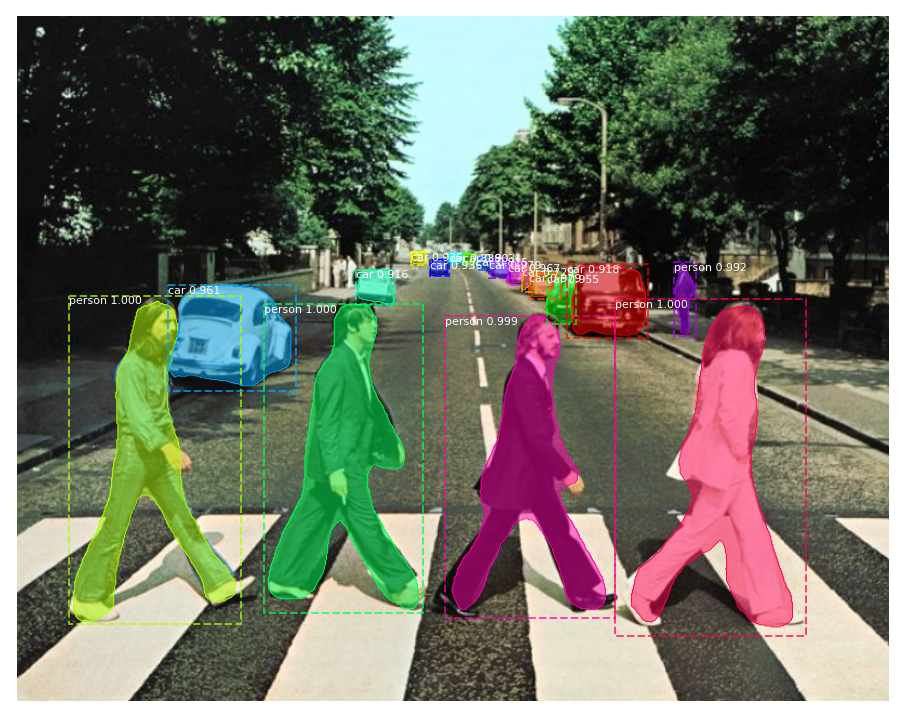

In [ ]:
from mrcnn import visualize

r = results[0]
class_names = [value for value in labels_to_names.values()]
visualize.display_instances(beatles_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (450, 814, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.300492525100708


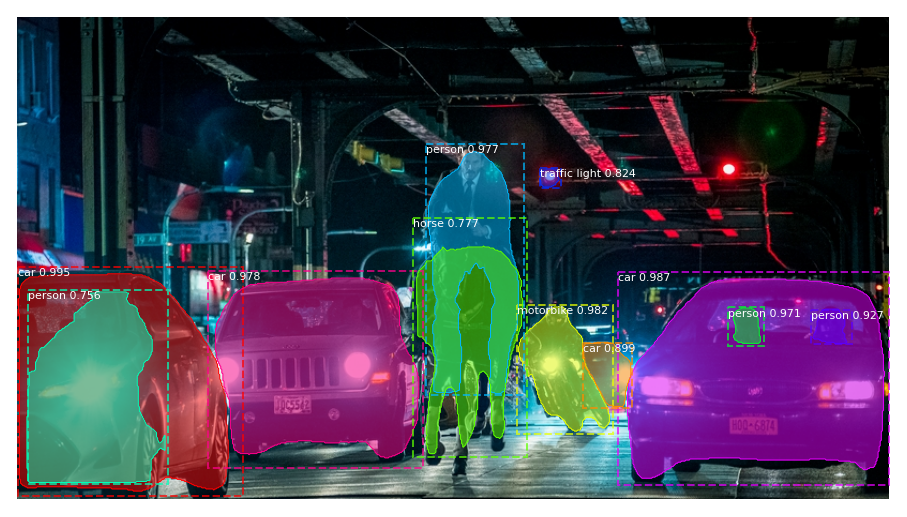

In [ ]:
import time

wick_img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
wick_img_rgb = cv2.cvtColor(wick_img, cv2.COLOR_BGR2RGB)

def get_segment_result(img_array_list, verbose):
    
    start_time = time.time()
    results = model.detect(img_array_list, verbose=1)
    
    if verbose==1:
        print('## inference time:{0:}'.format(time.time()-start_time))
    
    return results

r = get_segment_result([wick_img_rgb], verbose=1)[0]
visualize.display_instances(wick_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Video에 Segmentation 적용 
* MaskRCNN 패키지는 visualize.display_instances() 함수내부에서 matplotlib를 이용하여 자체 시각화를 수행. 
* Video segment instance에 적용하기 위해서 bounding box와 instance masking을 적용하는 별도의 함수 생성. 

In [ ]:
from mrcnn.visualize import *
import cv2

def get_segmented_image(img_array, boxes, masks, class_ids, class_names,
                      scores=None, show_mask=True, show_bbox=True, colors=None, captions=None):
   
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = img_array.shape[:2]

    masked_image = img_array.astype(np.uint32).copy()

    for i in range(N):
        color = np.array(colors[i])*255
        color = color.tolist()

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        
        if show_bbox:
            cv2.rectangle(img_array, (x1, y1), (x2, y2), color, thickness=1 )

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
            
        cv2.putText(img_array, caption, (x1, y1+8), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), thickness=1)
        
        # Mask
        # 클래스별 mask 정보를 추출 
        mask = masks[:, :, i]
        if show_mask:
            # visualize 모듈의 apply_mask()를 적용하여 masking 수행.
            img_array = apply_mask(img_array, mask, color)
            
            # mask에 contour 적용. 
            padded_mask = np.zeros(
                            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # padding 제거. 아래에서 verts를 32bit integer로 변경해야 polylines()에서 오류 발생하지 않음. 
                verts = verts.astype(np.int32)
                #x, y 좌표 교체
                verts = np.fliplr(verts) - 1
                cv2.polylines(img_array, [verts], True, color, thickness=1)
    
    return img_array


####  단일 IMAGE에 적용

Processing 1 images
image                    shape: (450, 814, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.2942969799041748


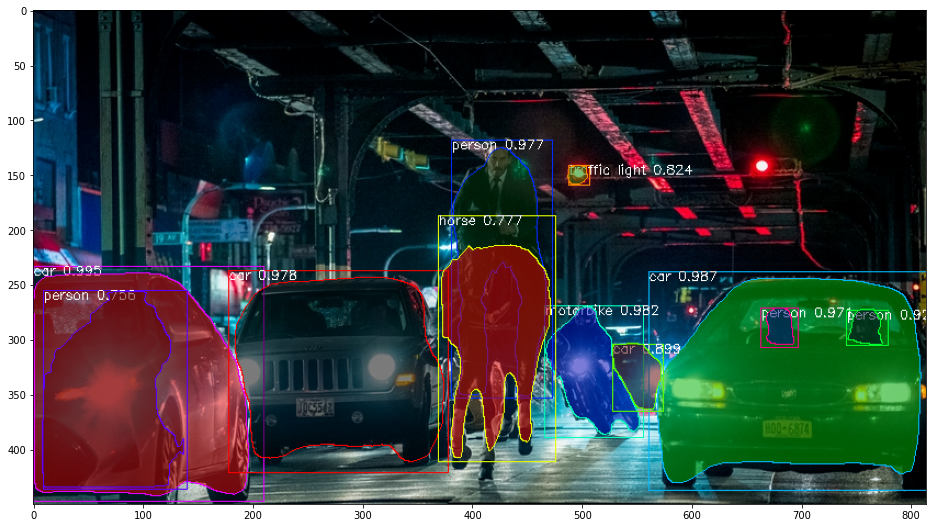

In [ ]:
import time

wick_img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
wick_img_rgb = cv2.cvtColor(wick_img, cv2.COLOR_BGR2RGB)

r = get_segment_result([wick_img_rgb], verbose=1)[0]
segmented_img = get_segmented_image(wick_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

plt.figure(figsize=(16, 16))
plt.imshow(segmented_img)

#### Video Segmentation 적용

In [ ]:
import time

video_input_path = os.path.join(default_dir, 'data/video/John_Wick_small.mp4')
# video output 의 포맷은 avi 로 반드시 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/John_Wick_small_matterport01.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
fps = round(cap.get(cv2.CAP_PROP_FPS))

vid_writer = cv2.VideoWriter(video_output_path, codec, fps, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("총 Frame 개수: {0:}".format(total))

frame_index = 0
while True:
    
    hasFrame, image_frame = cap.read()
    if not hasFrame:
        print('End of frame')
        break
    
    frame_index += 1
    print("frame index:{0:}".format(frame_index), end=" ")
    r = get_segment_result([image_frame], verbose=1)[0]
    segmented_img = get_segmented_image(image_frame, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
    vid_writer.write(segmented_img)
    
vid_writer.release()
cap.release()       

총 Frame 개수: 58
frame index:1 Processing 1 images
image                    shape: (460, 1072, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.264660120010376
frame index:2 Processing 1 images
image                    shape: (460, 1072, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.2686469554901123
frame index:3 Processing 1 images
image                    shape: (460, 1072, 3)

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/John_Wick_small_matterport01.avi '/content/gdrive/My Drive/John_Wick_small_matterport01.avi'

#### 다른 동영상에 적용. 

In [ ]:
video_input_path = os.path.join(default_dir, 'data/video/London_Street.mp4')
# video output 의 포맷은 avi 로 반드시 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/London_Street_matterport01.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
fps = round(cap.get(cv2.CAP_PROP_FPS))
vid_writer = cv2.VideoWriter(video_output_path, codec, fps, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("총 Frame 개수: {0:}".format(total))

import time

frame_index = 0
while True:
    
    hasFrame, image_frame = cap.read()
    if not hasFrame:
        print('End of frame')
        break
    
    frame_index += 1
    print("frame index:{0:}".format(frame_index), end=" ")
    r = get_segment_result([image_frame], verbose=1)[0]
    segmented_img = get_segmented_image(image_frame, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
    vid_writer.write(segmented_img)
    
vid_writer.release()
cap.release()       


In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/London_Street_matterport01.avi '/content/gdrive/My Drive/London_Street_matterport01.avi'